# Gene Score Matrix

Make a matrix of gene scores.

1. `metadata.tsv` with UMAP/densMAP coordinates and total fragments/insertions.
2. Single-cell counts matrix derived from snapATAC with corresponding peaks.
3. GTF
4. Config:
    - For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)

In [1]:
library(Matrix)
library(ggplot2)
library(patchwork)
library(GenomicRanges)
library(scales)
library(RColorBrewer)
library(DESeq2)
library(rtracklayer)
library(dplyr)
library(reshape2)
library(viridis)
library(ClusterR)
library(ComplexHeatmap)
library(ggplotify)
library(circlize)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

## Loading Inputs

### MetaData

In [3]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 68916     5

,barcode,sample,umap1,umap2,cells
,<fct>,<fct>,<dbl>,<dbl>,<chr>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA


In [4]:
# this is a kludge for now, clusters AND total insertions should also be present in same metaData as above
snapATAC_metaData = read.table("../../analysis/20200122_snapATAC/snapATAC_sessions/20200518_n76052/metadata.tsv", header = T)
rownames(snapATAC_metaData) = paste(snapATAC_metaData$sample, snapATAC_metaData$barcode, sep='_')

metaData$cluster = snapATAC_metaData[rownames(metaData), "cluster"] 
metaData$total_insertions = snapATAC_metaData[rownames(metaData), "TN"] 
head(metaData)

,barcode,sample,umap1,umap2,cells,cluster,total_insertions
,<fct>,<fct>,<dbl>,<dbl>,<chr>,<int>,<int>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC,5,53446
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT,5,27136
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC,5,23308
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG,6,18466
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA,5,3238
D0_AAACACGCTCGAGTGA,AAACACGCTCGAGTGA,D0,3.408866,-9.058377,D0_AAACACGCTCGAGTGA,6,50468


### Cluster Config

In [5]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#F4D5CD,Intermediate,12
2,2,#78A824,Pre-iPSC,15
3,3,#F01D35,Fibroblast-like,5
4,4,#E85F6D,Fibroblast-like,3
5,5,#B03743,Fibroblast,1
6,6,#7C2730,Fibroblast,2
7,7,#CF175A,Fibroblast-like,4
8,8,#CCCCCC,Doublets,17
9,9,#F7A6C2,Keratinocyte-like,6


In [6]:
# minor tweak
cluster_config[11,"description"] = "Partially\nreprogrammed"

### Insertions Count Matrix + Regions

In [7]:
pmat = readMM("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 409052

In [8]:
peak_regions = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.bed")
names(peak_regions) = c("chr", "bp1", "bp2")
peak_regions$site_name <- paste(peak_regions$chr, peak_regions$bp1, peak_regions$bp2, sep="_")
row.names(peak_regions) <- peak_regions$site_name
dim(peak_regions)
head(peak_regions)

[1] 409052      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_10355_10867,chr1,10355,10867,chr1_10355_10867
chr1_41995_42521,chr1,41995,42521,chr1_41995_42521
chr1_46067_46593,chr1,46067,46593,chr1_46067_46593
chr1_48475_48975,chr1,48475,48975,chr1_48475_48975
chr1_51286_52235,chr1,51286,52235,chr1_51286_52235
chr1_58648_59148,chr1,58648,59148,chr1_58648_59148


In [9]:
peak_regions_gr =  GRanges(sub("_", "-", sub("_", ":", rownames(peak_regions))))

In [10]:
# check if reads at OCT promoter (none in initial version)
sum(pmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), peak_regions_gr))])

[1] 12150

In [11]:
pmatRowSums = Matrix::rowSums(pmat)

In [12]:
# these values should correlate well (reads in peaks vs total reads)
cor(pmatRowSums, metaData$total_insertions, method='spearman')

[1] 0.9899533

### Gene Set

In [13]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gencode.basic.tx.hg38 = subset(subset(gencode.basic.hg38, gene_type=="protein_coding"), type=="transcript")
head(gencode.basic.tx.hg38, 3)
length(gencode.basic.tx.hg38)

Warning message in readGFF(filepath, version = version, filter = filter):
“connection is not positioned at the start of the file, rewinding it”


GRanges object with 3 ranges and 21 metadata columns:
      seqnames        ranges strand |   source       type     score     phase
         <Rle>     <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1   65419-71585      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1   69055-70108      + |  ENSEMBL transcript      <NA>      <NA>
  [3]     chr1 450703-451697      - |   HAVANA transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
  [3] ENSG00000284733.1 protein_coding      OR4F29           2  HGNC:31275
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 

[1] 58073

In [14]:
tx.hg38 = gencode.basic.tx.hg38

In [15]:
tss.hg38 = unique(resize(tx.hg38, width=1, fix='start'))

In [16]:
prom.hg38 = promoters(tss.hg38, upstream = 100, downstream = 100)
head(prom.hg38, 2)

GRanges object with 2 ranges and 21 metadata columns:
      seqnames      ranges strand |   source       type     score     phase
         <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1 65319-65518      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1 68955-69154      + |  ENSEMBL transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 ENST00000641515.2  protein_coding       OR4F5-202
  [2] OTTHUMG00000001094.4 ENST00000335137.4  protein_coding       OR4F5-201
      transcript_support_level    

In [17]:
unique_prom_genes = names(table(prom.hg38$gene_name)[which(table(prom.hg38$gene_name)==1)])

## Gene Score Matrix

### Pseudo-bulk matrix

In [18]:
# CAREFUL: reassigning clusters to their new cluster labels! 
# ensure cluster_config is in order
new_cluster_per_cell = cluster_config$new_cluster[metaData$cluster]

agg_matrix = sparseMatrix(i=new_cluster_per_cell,
                         j=seq(1,nrow(pmat)),
                         x=1L,
                         dims=c(length(table(new_cluster_per_cell)), nrow(pmat)))

In [19]:
cts = as.matrix(agg_matrix %*% pmat)
colnames(cts) = sub("_", "-", sub("_", ":", rownames(peak_regions)))
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)
dim(cts)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18
chr1:10355-10867,65,60,47,53,6,14,16,26,16,39,26,68,26,13,31,16,15,0
chr1:41995-42521,56,29,62,76,4,16,16,35,8,34,22,43,38,14,1,9,15,0
chr1:46067-46593,13,16,22,47,2,16,4,13,15,55,51,73,64,24,44,12,26,0
chr1:48475-48975,13,5,9,21,9,1,10,22,50,64,32,82,13,6,2,1,10,0
chr1:51286-52235,27,16,25,25,1,11,10,3,9,31,3,70,76,19,201,125,126,0
chr1:58648-59148,7,5,12,14,2,11,15,23,56,37,10,56,25,2,4,2,5,0


[1] 409052     18

In [20]:
# removing cluster_18 (iPSC) for now since it has very few cells
cts = cts[,1:17]

In [21]:
sum(rowSums(cts<10)==0)

[1] 137543

### Inverse Distance Weighted Gene Score

In [22]:
tx_with_peak_at_prom = unique(tss.hg38[queryHits(findOverlaps(tss.hg38+100, peak_regions_gr))]$transcript_name)

In [23]:
distal_overlaps = findOverlaps(tss.hg38+100000, peak_regions_gr)
distal_overlaps

Hits object with 1949910 hits and 0 metadata columns:
            queryHits subjectHits
            <integer>   <integer>
        [1]         1           1
        [2]         1           2
        [3]         1           3
        [4]         1           4
        [5]         1           5
        ...       ...         ...
  [1949906]     51887      409039
  [1949907]     51887      409040
  [1949908]     51900      409044
  [1949909]     51917      409048
  [1949910]     51918      409048
  -------
  queryLength: 51948 / subjectLength: 409052

In [24]:
distal_summed_gene = cts[subjectHits(distal_overlaps),]

gene_peak_coeff = 1000*(1+abs(mid(peak_regions_gr[subjectHits(distal_overlaps)]) - start(tss.hg38[queryHits(distal_overlaps)])))^(-0.7)

distal_summed_gene = aggregate(gene_peak_coeff * distal_summed_gene, list(queryHits(distal_overlaps)), sum)

# remove transcripts with duplicate entries (e.g. CD99-201 that is on chrY and chrX)
tx_names = prom.hg38[distal_summed_gene$Group.1]$transcript_name
distal_summed_gene = distal_summed_gene[!duplicated(tx_names), ]
rownames(distal_summed_gene) = tx_names[!duplicated(tx_names)]
distal_summed_gene$Group.1 = NULL

# only keep those with a peak at the TSS
distal_summed_gene = distal_summed_gene[rownames(distal_summed_gene) %in% tx_with_peak_at_prom , ]

# DESeq2 normalize
distal_summed_gene = as.data.frame(t(t(distal_summed_gene)/estimateSizeFactorsForMatrix(distal_summed_gene)))

head(distal_summed_gene, 2)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SAMD11-202,22475.78,20786.63,28075.91,24598.99,24260.97,25964.15,22258.65,22301.38,19328.52,22566.16,24988.10,20103.03,19309.46,21421.55,13326.19,13981.46,18801.64
SAMD11-213,22417.93,20732.72,27991.85,24529.94,24192.86,25896.06,22204.74,22245.03,19280.94,22506.92,24918.37,20048.93,19256.86,21358.86,13290.60,13943.97,18748.54


In [25]:
log_tx_score = log2(1+distal_summed_gene)
head(log_tx_score)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SAMD11-202,14.45615,14.34344,14.77710,14.58637,14.56641,14.66429,14.44214,14.44491,14.23852,14.46194,14.60901,14.29520,14.23709,14.38684,13.70208,13.77133,14.19865
SAMD11-213,14.45243,14.33969,14.77277,14.58231,14.56235,14.66050,14.43864,14.44126,14.23496,14.45815,14.60498,14.29131,14.23316,14.38261,13.69823,13.76746,14.19457
NOC2L-201,15.34138,15.27438,15.38742,15.36806,15.14531,15.30329,15.16849,15.12179,15.26394,15.20829,15.28431,15.07274,15.10977,15.03955,14.69376,14.99626,15.12007
KLHL17-201,14.91777,14.83294,14.97023,14.93437,14.67337,14.95916,14.83573,14.78975,14.80620,14.79596,14.80847,14.65444,14.68979,14.57316,14.17187,14.42210,14.56827
KLHL17-205,14.97540,14.88982,15.02302,14.98683,14.71361,15.01044,14.89164,14.84652,14.86705,14.84902,14.85640,14.71181,14.74710,14.62480,14.22161,14.47110,14.61554
PLEKHN1-203,15.52938,15.54370,15.76241,15.93346,15.70057,15.94807,15.75940,15.53146,15.19132,15.62442,15.42940,15.21663,15.37629,14.87617,14.84608,14.95750,15.27715


In [26]:
# pick one tx per gene
# picking one with max var/mean ratio
var_mean_ratio = data.frame(vmr=rowVars(as.matrix(log_tx_score))/rowMeans(as.matrix(log_tx_score)),
                           tx=rownames(log_tx_score),
                           gene=sub("-2[0-9]+", "",rownames(log_tx_score)))

select_tx = (var_mean_ratio %>% group_by(gene) %>% filter(vmr==max(vmr)))$tx

In [27]:
log_selected_tx_score = log_tx_score[as.character(select_tx), 1:16]
dim(log_selected_tx_score)
head(log_selected_tx_score)

[1] 16633    16

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SAMD11-202,14.45615,14.34344,14.77710,14.58637,14.56641,14.66429,14.44214,14.44491,14.23852,14.46194,14.60901,14.29520,14.23709,14.38684,13.70208,13.77133
NOC2L-201,15.34138,15.27438,15.38742,15.36806,15.14531,15.30329,15.16849,15.12179,15.26394,15.20829,15.28431,15.07274,15.10977,15.03955,14.69376,14.99626
KLHL17-205,14.97540,14.88982,15.02302,14.98683,14.71361,15.01044,14.89164,14.84652,14.86705,14.84902,14.85640,14.71181,14.74710,14.62480,14.22161,14.47110
PLEKHN1-202,15.66369,15.68207,15.90166,16.08123,15.84419,16.09173,15.90258,15.66733,15.31770,15.76483,15.55893,15.34746,15.51306,14.99051,14.98050,15.08627
HES4-202,15.23748,15.12342,15.49988,15.37849,15.43251,15.42977,15.36797,15.31755,15.13409,15.20901,15.24109,14.87529,14.99070,14.80044,14.53907,14.89541
ISG15-202,14.97390,14.87871,15.21114,15.09895,15.13059,15.16431,15.10277,15.03872,14.86476,14.93565,14.97480,14.64703,14.75271,14.57571,14.32815,14.66591


In [28]:
# filter genes to top var/mean
TOPK = 5000
selected_genes = rownames(log_selected_tx_score)[rev(order(rowVars(as.matrix(log_selected_tx_score))/rowMeans(as.matrix(log_selected_tx_score))))][1:TOPK]

In [29]:
"KLF4" %in% (sub("-2[0-9]+", "",selected_genes))

[1] FALSE

In [30]:
log_selected_tx_znorm = t(scale(t(log_selected_tx_score[selected_genes, ])))
head(log_selected_tx_znorm)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16
TBX22-201,-1.8354797,-0.85618096,-0.2747048,-0.06139370,0.2288283,0.13972065,-1.83547968,-0.6075650,-0.48903804,0.05550017,0.06572354,0.578506847,0.9931658,0.7992703,1.549796,1.5493299
CTNND2-214,-0.1734229,-0.08241294,-0.0723174,0.01011017,-2.4283008,0.03492371,-2.21926648,0.2471813,0.15910019,0.27055458,0.15132330,0.409838099,0.7302900,0.5245507,1.172634,1.2652140
APCS-201,-2.3873582,-2.38333233,0.3412863,0.14027305,0.3383967,-0.53048287,-0.02946828,0.2877515,0.12999844,0.45344579,0.07385681,0.414913216,0.6912848,0.6488358,1.087485,0.7231144
EPDR1-204,-1.5385127,-0.70840794,-0.3530262,-0.13114305,0.7930072,-0.37257090,-1.28401039,0.2913831,0.07779267,-1.58089397,-0.10490498,-0.070994219,0.7525235,0.8809994,1.767085,1.5816735
GPR141-202,-1.4852404,-0.75362320,-0.3900665,-0.17301731,0.7866577,-0.39431180,-1.21713344,0.2703454,0.04805272,-1.53040028,-0.15007092,-0.105331555,0.7533361,0.8860611,1.819353,1.6353899
GABRA3-201,-0.1579629,-0.33642246,-0.2011207,0.25372012,-3.0431424,-0.39547393,0.20183018,0.3779908,-0.22179165,-0.04060689,-0.38934285,-0.003187075,0.6001553,0.3859019,1.350660,1.6187921


## Clustering

In [31]:
# scale counts by width of bin
cts_to_cluster = log_selected_tx_znorm

In [32]:
# ADD RAND SEED - not required
km_mb = MiniBatchKmeans(cts_to_cluster, 
                        batch_size = 1000,
                        clusters=10,
                        num_init = 50, 
                        verbose = FALSE)

In [33]:
# reorder based on weighted mean
pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

# distance    = dist(t(scale(t(km_mb$centroids))))
# cluster     = hclust(distance, method="ward")
# dendrogram  = as.dendrogram(cluster)
# rowInd = rev(order.dendrogram(dendrogram))

# rowInd = order(-rowSums(t(seq(1,ncol(km_mb$centroids))*t(km_mb$centroids))))
rowInd = order(-apply(km_mb$centroids, 1, which.max))


pr_mb = order(rowInd)[pr_mb]

In [34]:
rowInd

[1]  2  3  6  9 10  8  4  1  5  7

In [35]:
sort(table(pr_mb))

pr_mb
  9   8   7   5   6   2   4  10   3   1 
165 189 217 344 449 609 619 643 862 903 

## Plotting

In [36]:
gene_score_to_plot = log_selected_tx_znorm
# gene_score_order = rownames(gene_score_to_plot)[order(-rowSums(t(seq(1,ncol(gene_score_to_plot))*t(gene_score_to_plot))))]
gene_score_order = order(pr_mb)

In [37]:
gene_score_ordered = gene_score_to_plot[gene_score_order, ]

In [38]:
# ermove transcript name
rownames(gene_score_ordered) = sub("-2[0-9]+", "", rownames(gene_score_ordered))

In [39]:
melted_matrix_to_plot = melt(as.matrix(gene_score_ordered))
melted_matrix_to_plot$Var1 = factor(melted_matrix_to_plot$Var1, levels = rownames(gene_score_ordered))
melted_matrix_to_plot$Var2 = factor(melted_matrix_to_plot$Var2, levels = colnames(gene_score_ordered))
head(melted_matrix_to_plot, 2)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,TBX22,cluster_1,-1.835480
2,EPDR1,cluster_1,-1.538513


In [40]:
cluster_config_colourbar_df = cluster_config
cluster_config_colourbar_df$text = paste(cluster_config_colourbar_df$new_cluster, 
                                         cluster_config_colourbar_df$description,
                                        sep =' - ')
cluster_config_colourbar_df = cluster_config_colourbar_df[order(cluster_config_colourbar_df$new_cluster), ]

# choose clusters properly
# Removing those not selected currently
cluster_config_colourbar_df = cluster_config_colourbar_df[1:16, ]
cluster_config_colourbar_df$text = factor(cluster_config_colourbar_df$text, 
                                         levels=cluster_config_colourbar_df$text)


cluster_colourbar <- ggplot(cluster_config_colourbar_df, aes(x=as.factor(text), 
                                                y=1, 
                                                fill = as.factor(text), 
                                                label=as.factor(text))) +
  geom_bar(stat="identity") +
#   xlab("Cluster") +
  theme_void() +
  scale_fill_manual(values = cluster_config_colourbar_df$colour) +
  theme(legend.position = 'none',
        axis.text.x = element_text(size=12, angle=90, hjust=1),
        axis.title.x = element_blank()) #element_text(size=16))

In [41]:
rownames(gene_score_ordered)[grep("GATA", rownames(gene_score_ordered))]

[1] "GATA4" "GATA5"

In [115]:
GENES_TO_LABEL = c("MAP2", "GPM6A","JAKMIP2", # neural like
                   "KRT16", # keratinocyte
                   "CDH1", # early on                   
                   "OAS1", # immune response
                  "COL1A1", "LSP1", "ACTA2","RUNX1","MMP2", "MMP1", # fibroblast
                  "POU5F1", "NANOG", "SOX2", "ESRRB",  "LIN28A", "ZFP42", "TERT", "SALL4", "UTF1", # pluripotency
                   "DPPA4", "FGF4", "TCF21", "COL6A3", "TFAP2C", "DPPA5") # pluripotency
# overlapping genes

In [116]:
GENES_TO_LABEL[!GENES_TO_LABEL %in% melted_matrix_to_plot$Var1]

character(0)

In [117]:
heatmap <- ggplot(data = melted_matrix_to_plot, 
       aes(x = Var2, y = Var1, fill = value)) +
geom_tile()  + ylab(NULL) + xlab(NULL) +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(-1.5, 1.5), oob=squish, option = "D", name="Z-score Log2\nGene Score") +
# scale_fill_gradient2(low="darkseagreen3", mid="cornsilk1", high="firebrick3",
#                     limits=c(-1.5, 1.5), oob=squish, name="Z-score Log2\nGene Score") +
scale_y_discrete(breaks=GENES_TO_LABEL, position = "right") + 
theme(axis.text.x = element_blank() , # element_text(angle = 90, hjust = 1),
        axis.text.y=element_text(size=10),
#       axis.ticks.y=element_blank(),
     axis.ticks.x=element_blank()) 

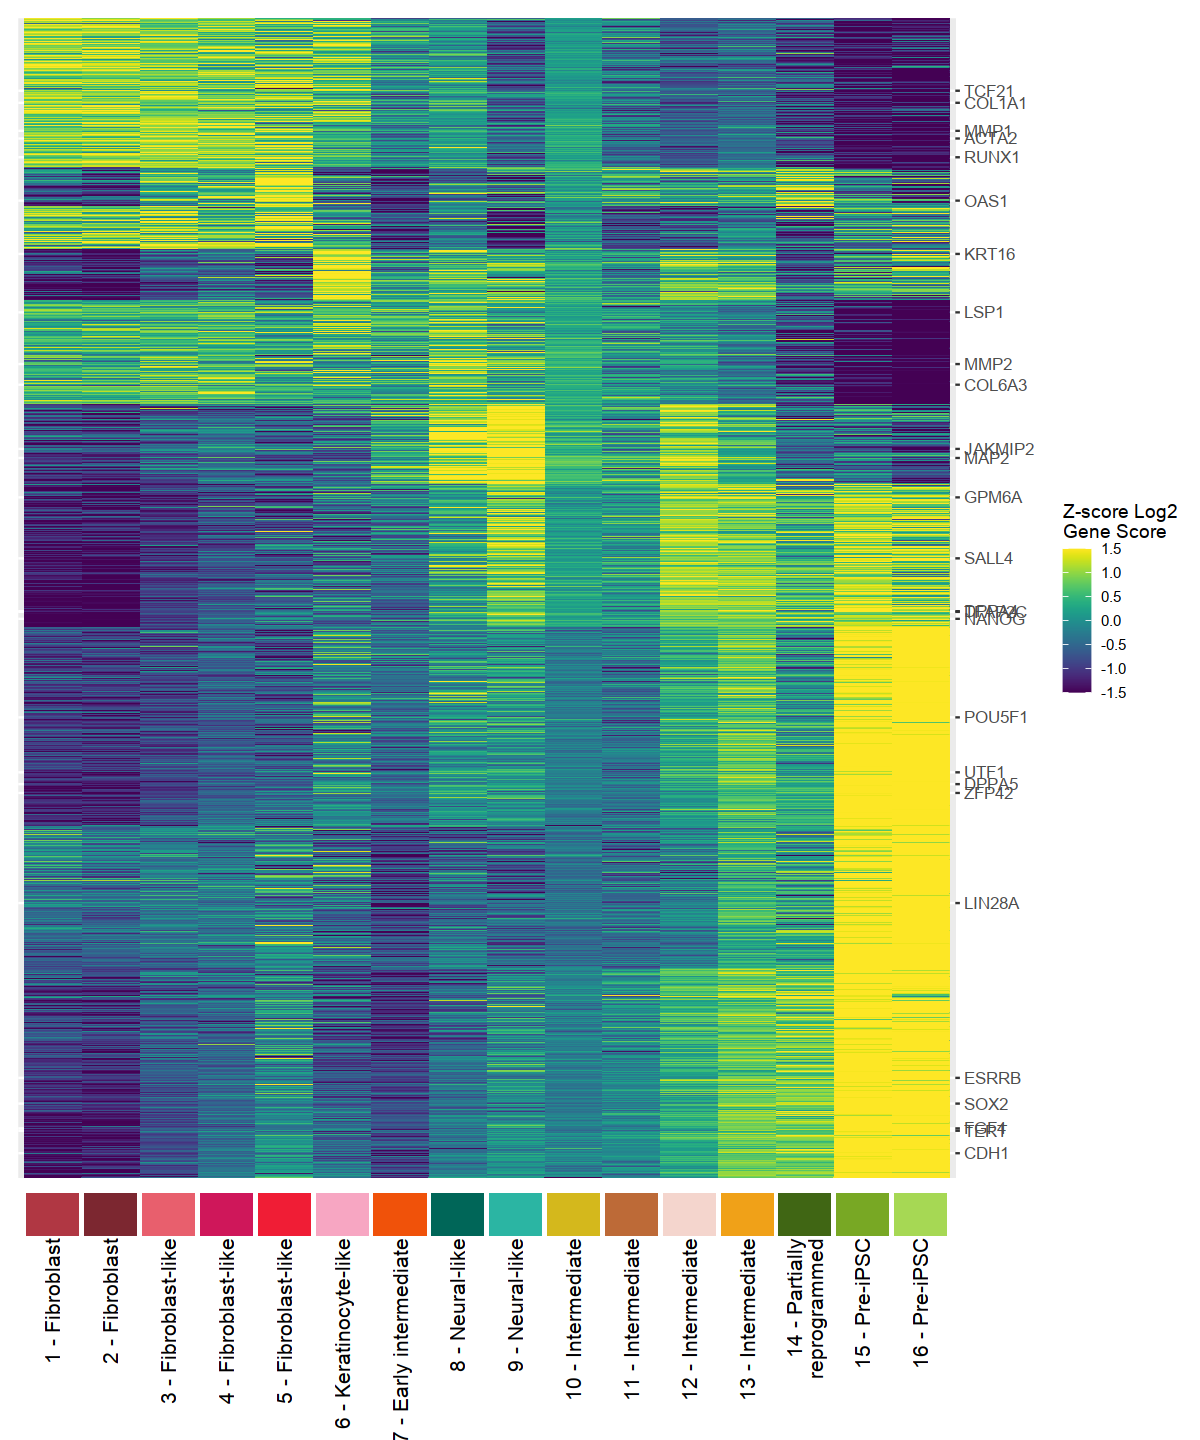

In [118]:
options(repr.plot.width = 10, repr.plot.height = 12)

heatmap_with_colourbar = wrap_plots(heatmap, cluster_colourbar, nrow=2, heights=c(10,0.4))
heatmap_with_colourbar

In [119]:
intervs = seq(from=-2, to=2, by=0.2)
col_heatmap = colorRamp2(intervs, viridis(length(intervs)))

In [120]:
matrix_to_plot = as.matrix(gene_score_ordered)[rev(seq(1,nrow(gene_score_ordered))), ]

ch_heatmap = Heatmap(matrix_to_plot,
       cluster_rows=F,
       cluster_columns=F,
       col=col_heatmap,
       show_row_names=F,
       show_column_names=F,
         heatmap_legend_param = list(title = "Z-score Log2\nGene Score")) +
rowAnnotation(link = anno_mark(at = which(rownames(matrix_to_plot) %in% GENES_TO_LABEL), 
        labels = rownames(matrix_to_plot)[rownames(matrix_to_plot) %in% GENES_TO_LABEL], 
        labels_gp = gpar(fontsize = 10), padding = unit(1, "mm"))) 

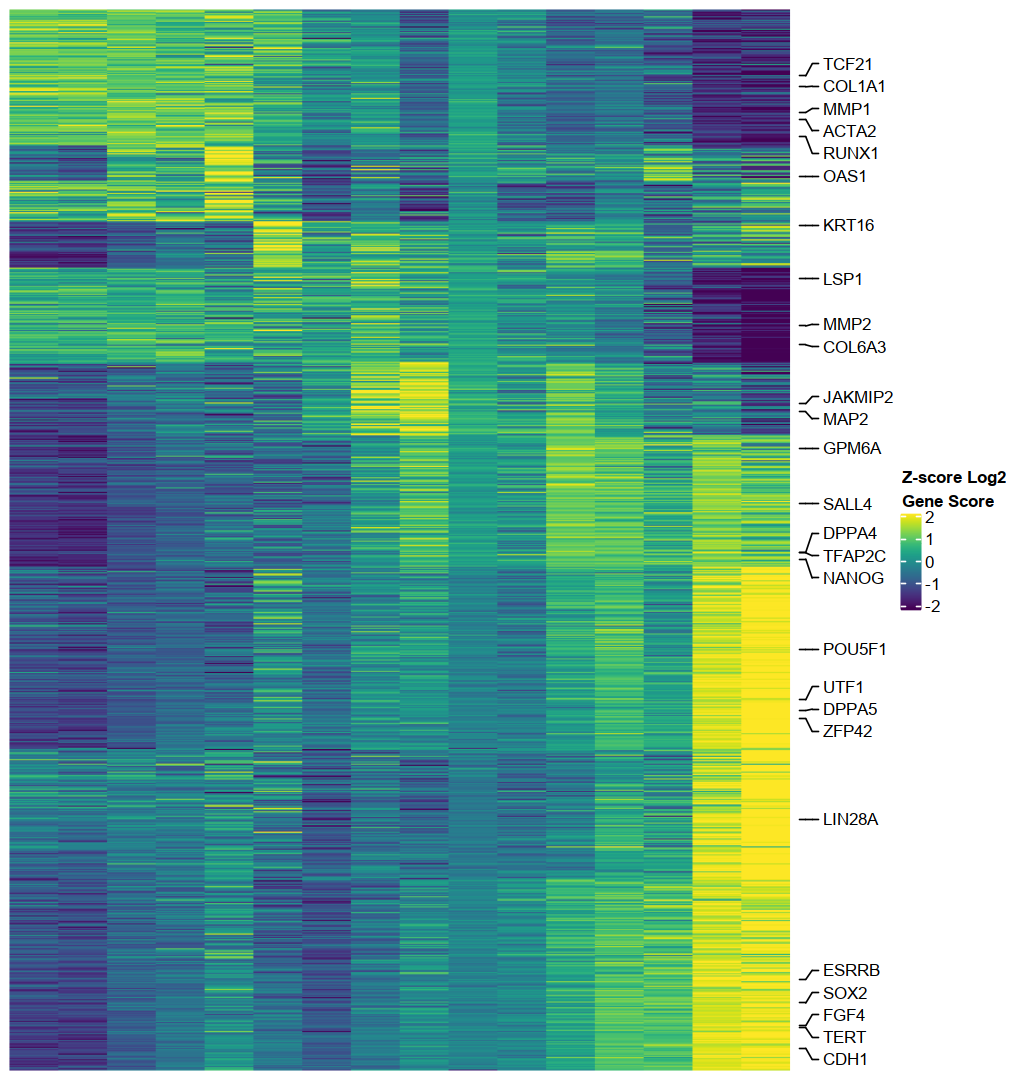

In [199]:
ch_heatmap

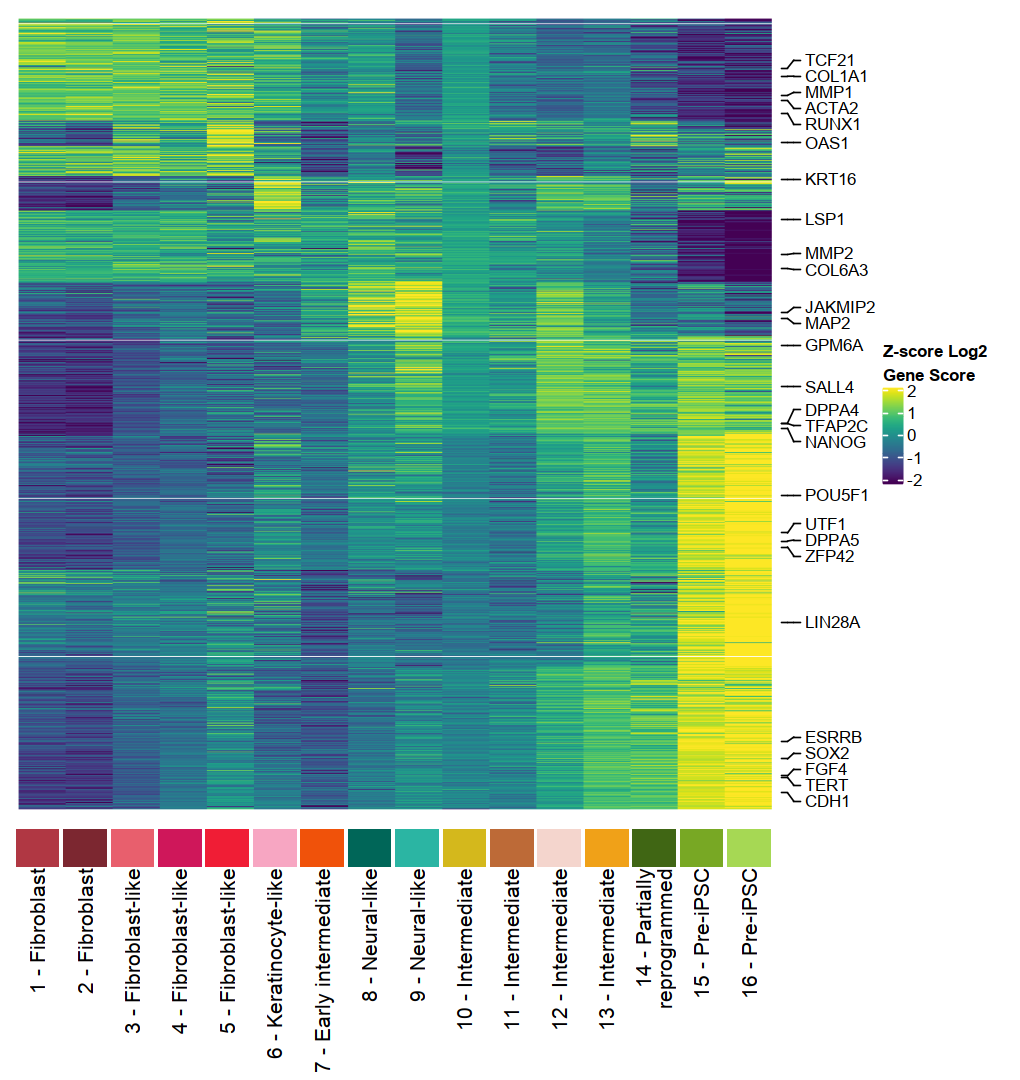

In [196]:
options(repr.plot.width = 8.5, repr.plot.height = 9)

ch_heatmap_with_colourbar <- wrap_plots(as.ggplot(grid.grabExpr(draw(ch_heatmap))), 
                               wrap_plots(cluster_colourbar, plot_spacer(), nrow=1, widths=c(1,0.28)), 
                               ncol=1, heights=c(10,0.5))
ch_heatmap_with_colourbar

In [197]:
# saveRDS(heatmap_with_colourbar, file=sprintf("subfigs/%s_gene_score_heatmap.rds",
#                                    format(Sys.Date(), "%Y%m%d")))

In [198]:
saveRDS(ch_heatmap_with_colourbar, file=sprintf("subfigs/%s_gene_score_ch_heatmap.rds",
                                   format(Sys.Date(), "%Y%m%d")))

### Auxiliary- Gene Score Plots


In [183]:
query = "^POU5F1-"
rownames(distal_summed_gene)[grepl(query, rownames(distal_summed_gene))]
GENE = rownames(distal_summed_gene)[grepl(query, rownames(distal_summed_gene))][1]

[1] "POU5F1-201" "POU5F1-202" "POU5F1-209"

In [184]:
as.character(prom.hg38[prom.hg38$transcript_name==GENE]+1000)

[1] "chr6:31169583-31171782:-"

In [185]:
df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                distal_gene_score=as.numeric(distal_summed_gene[GENE, ])[cluster_config[metaData$cluster, "new_cluster"]])
# shuffle so days don't overlap
df = df[sample(dim(df)[1], 25000), ]


gs_plot <- ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.5, alpha=1, stroke=0, aes(x=umap1 , y=umap2, col=log2(1+distal_gene_score))) +
# ggtitle(sub("-2[0-9]+", "",GENE)) + 
scale_color_viridis_c(option = "D", name="Log2\nGene\nScore") +
theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()

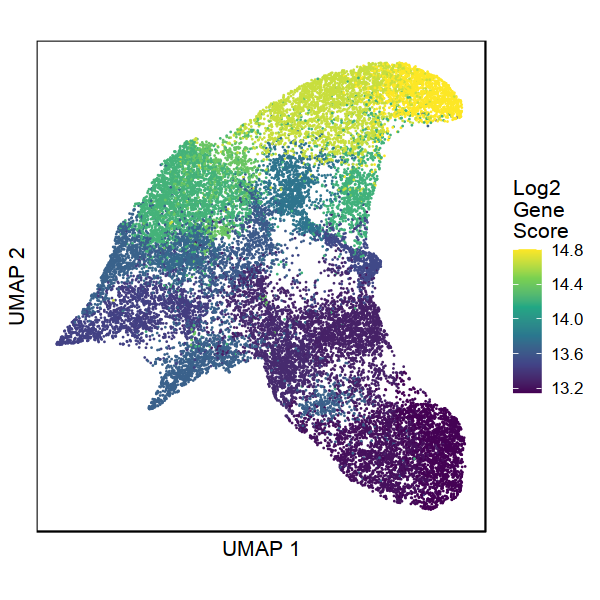

In [186]:
options(repr.plot.width = 5, repr.plot.height = 5)
gs_plot

In [187]:
saveRDS(gs_plot, file=sprintf("./subfigs/%s_POU5F1_gs.rds",
                                   format(Sys.Date(), "%Y%m%d")))